# Ensemble Methods

## Sources of Error

There are three main sources of error in machine learning:
1. Bias: The error is caused by unrealistic assumptions.
2. Variance: The error is caused by sensitivity to small changes in he training set.
3. Noise: The error is caused by the variance of the observed values.

These three elements together, forms the Bias-Variance decomposition:

$$
E[(y_i-\hat{f}[x_i])^2] = \left ( E[\hat{f}[x_i]-f[x_i]]\right )^2 + V[\hat{f}[x_i]] + \sigma_{\epsilon}^2
$$

Ensemble methods combines several learners in order to create a met=learner that outperforms a single model by reducing the variance of a learner at constant bias.

## Basic Concepts

In the previous section, we showed that the bagging method can reduce the variance at constant bias. It seems to be a well suited method for high-variance and low-bias. A regression problem is approached by fitting a same regression tree to data, and averaging the result. For a classification, we use the vote of the majority as the predicted class. Random Forests is a modification of the bagging, in which attempt to train a large collection of de-correlated trees, and average them. It is a very popular algorithm, implemented in many packages. Decision trees are recognized to be highly eager to overfit. This results in high variance predictions. A way to address this problem is using the ensemble procedure to reduce the variance. This is the general view of the random forest algorithm.

The ensemble methods attempts to combine predictors in a meta predictor that has better performance than each individual predictor alone. This is a machine learning realization of the so-called wisdom of the crowds. There are many ways to use ensemble methods to build a machine learning model. The simple one, is to use it as the final step in the project, after you had built some good and explainable models or good and less interpretable models, you can mix than in a pool or average than as a way combine they strengths and mitigates they weakness. The other one, is to train a model custom made to be combined. Roughly speaking, there are two types of ensemble methods. The first one combines different machine learning models as chosen by user, such as VotingClassifier. The second type, combines many versions of the same model, such as XGBoost and random forests.

Let us suppose that one collects the predictions of 10 models. Ensemble methods allows you to strategically combine those 10 predictions in a single model that is more accurate than any of the models alone. The averaging model or the majority voting principle are methods that combine the individual predictions, assuming that the base estimators are distinct. In the regression problem, this is just a simple average. In classification, is the class predicted by the majority of the predictors or the average predicted probability.

A random forest consist of hundreds or thousands of decision trees whose predictions are combined for the final result. It is one of the most popular ensemble models. They use majority voting for classification and average of all models as a regressor and also uses a special method such as bagging, short for bootstrap aggregation to select individual trees.

Random Forests and Bagging has lot of similarities, most related with the usage of independent estimator over bootstrapped samples to reduce variance. The crucial difference is that random forests also includes a random selection of of sub-samples, without replace, of the feature variables to optimize the split procedure. This additional randomness reduces the correlation between the estimation and the overall variance. Like bagging, the random forests reduces the variance of the prediction without overfitting. Also, random forests evaluated the feature importance. On top of that random forest provides out-of-bag estimates by construction. However, it is possible that random forest bias is greater than a single tree.

We begin with the classification problem. Using the same training dataset, we start by training m different classifiers. Independent of the approach, the same picture applies as schematics:

The class prediction is obtained by combining the predicted class of each one of the $m$ model and select the class label, $\hat{y}$, that received most votes:

$$
\hat{y} = mode\{C_1(\vec{x}),...,C_m(\vec{x})\}.
$$
Consider the binary classification problem, in which the $class1 = -1$ and $class2= +1$. One can write the majority vote prediction as:

$$
C(\vec{x}) = sign \left[ \sum_j^m C_j(\vec{x})\right] = \begin{cases}
                                                          \:\:\:\:1 \: \:if \: \sum_jC_j(\vec{x}) \geq 0 \\
                                                         -1 \:\: otherwise
                                                         \end{cases}
$$

A simple way to illustrate why ensemble methods work best is to use combinatorial analysis. Let $\xi$ be the error rate of each of a set of $n$ estimators. Also assumes that they are uncorrelated and the errors are independent. Under those assumptions, the error probability can expressed as the probability mass function of a binomial distribution:

$$

P(y \geq k ) = \sum_{k}^n \binom{n}{k}\xi^k(1-\xi)^{n-k} = \xi_{ensemble}

$$

if we took $n=11$ and $\xi=0.25$, we have:

$$
P(y \geq k ) = \sum_{6}^{11} \binom{11}{6}0.25^k(1-0.25)^{n-k} = 0.034
$$

# Voting Classifiers

This method allows to combine different classifiers with different weights for confidence, thus building a stronger meta-classifier that ablances out the individual classifiers weakness in a particular dataset. In mathematical terms, the so-called weighted majority vote is given by:

$$
\hat{y} = arg\:max \sum_{j=1}^{m} w_i\chi_{A}(C(\vec{x})=i),

$$
where $w_j$ is the weight associated with the $j-$th classifier $C_j$; $\hat{y}$ is the predicted class label of the ensemble; A is the set of unique class labels; $\chi_A$ is the classification function. For equal weights, the equations simplifies to:

$$
\hat{y} = mode\{C_1(\vec{x}),...,C_m(\vec{x})\}.
$$

Models such as logistic regression and decision trees returns the probability of the instance to be part of each class. Using the predicted class probability, we can test if the majority vote is well calibrated. Não, the prediction output is the weighted average of the probabilities:
$$
\hat{y} = arg\:max \sum_{j=1}^mw_jp_{ij},
$$
where, $p_{ij}=p_j(i|\vec{x})$, is the predicted probability of the $jth$ classifier for class label $i$. The following lines of code implements the MajorityVoteClassifier:

In [1]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

In [6]:
class MajorityVoteClassifier(BaseEstimator,
                             ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='classlabel')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Matrix of training examples.

        y : array-like, shape = [n_examples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote=%r)"
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d classifiers'
                             % (len(self.weights), len(self.classifiers)))

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Matrix of training examples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_examples]
            Predicted class labels.

        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                lambda x:
                np.argmax(np.bincount(x,
                                      weights=self.weights)),
                axis=1,
                arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Training vectors, where n_examples is the number of examples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_examples, n_classes]
            Weighted average probability for each class per example.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out['%s__%s' % (name, key)] = value
            return out

A few explanation came in hand to correct specify model functionalities. The BaseEstimator and ClassifierMixin parent classes adds some functionalities for free into our custom made class, including some useful tools such as get_params, set_params and score. The idea is to import the useful methods from sckitlearn to be conveniently implemented in class that takes a few classifiers as inputs and outputs a blended prediction. Lets take a look:

In [3]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =train_test_split(X, y,
                                                   test_size=0.5,
                                                   random_state=1,
                                                   stratify=y)

In [4]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

clf1 = LogisticRegression(penalty='l2',
                          C=0.001,
                          solver='lbfgs',
                          random_state=1)

clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=0)

clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']

print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]


In [7]:
# Majority Rule (hard) Voting

mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
ROC AUC: 0.98 (+/- 0.05) [Majority voting]


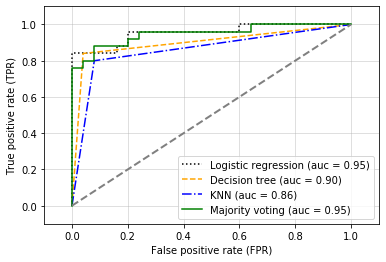

In [8]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):

    # assuming the label of the positive class is 1
        y_pred = clf.fit(X_train,
                     y_train).predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=y_pred)
        roc_auc = auc(x=fpr, y=tpr)
        plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')


#plt.savefig('images/07_04', dpi=300)
plt.show()

In [9]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

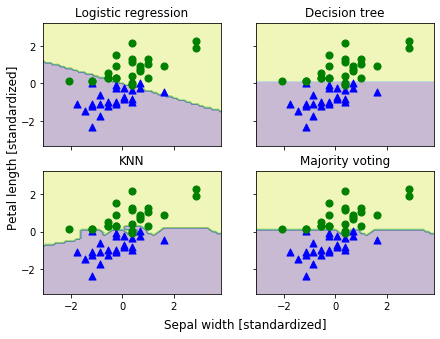

In [10]:
from itertools import product

all_clf = [pipe1, clf2, pipe3, mv_clf]

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2,
                        sharex='col',
                        sharey='row',
                        figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        all_clf, clf_labels):
    clf.fit(X_train_std, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)

    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0],
                                  X_train_std[y_train==0, 1],
                                  c='blue',
                                  marker='^',
                                  s=50)

    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0],
                                  X_train_std[y_train==1, 1],
                                  c='green',
                                  marker='o',
                                  s=50)

    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -5.,
         s='Sepal width [standardized]',
         ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5,
         s='Petal length [standardized]',
         ha='center', va='center',
         fontsize=12, rotation=90)

#plt.savefig('images/07_05', dpi=300)
plt.show()

In [11]:
mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=1)]],
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf__intercept_scaling': 1,
 'pipeline-1__clf__l1_ratio': None,
 'pipeline-1__clf__max_iter': 100,
 'pipeline-1__clf__m

In [12]:
from sklearn.model_selection import GridSearchCV


params = {'decisiontreeclassifier__max_depth': [1, 2],
          'pipeline-1__clf__C': [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator=mv_clf,
                    param_grid=params,
                    cv=10,
                    scoring='roc_auc')
grid.fit(X_train, y_train)

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_['mean_test_score'][r],
             grid.cv_results_['std_test_score'][r] / 2.0,
             grid.cv_results_['params'][r]))

0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [13]:
print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
Accuracy: 0.98


In [14]:
grid.best_estimator_.classifiers


[Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]])]

In [15]:
mv_clf = grid.best_estimator_
mv_clf.set_params(**grid.best_estimator_.get_params())

MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc', StandardScaler()),
                                                    ('clf',
                                                     LogisticRegression(C=0.001,
                                                                        random_state=1))]),
                                    DecisionTreeClassifier(criterion='entropy',
                                                           max_depth=1,
                                                           random_state=0),
                                    Pipeline(steps=[('sc', StandardScaler()),
                                                    ('clf',
                                                     KNeighborsClassifier(n_neighbors=1))])])

In [16]:
mv_clf

MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc', StandardScaler()),
                                                    ('clf',
                                                     LogisticRegression(C=0.001,
                                                                        random_state=1))]),
                                    DecisionTreeClassifier(criterion='entropy',
                                                           max_depth=1,
                                                           random_state=0),
                                    Pipeline(steps=[('sc', StandardScaler()),
                                                    ('clf',
                                                     KNeighborsClassifier(n_neighbors=1))])])

In [10]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

# if the Wine dataset is temporarily unavailable from the
# UCI machine learning repository, un-comment the following line
# of code to load the dataset from a local path:

# df_wine = pd.read_csv('wine.data', header=None)

# drop 1 class
df_wine = df_wine[df_wine['Class label'] != 1]

y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values

In [11]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =train_test_split(X, y,
                     test_size=0.2,
                     random_state=1,
                     stratify=y)

In [12]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy',
                              max_depth=None,
                              random_state=1)

bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500,
                        max_samples=1.0,
                        max_features=1.0,
                        bootstrap=True,
                        bootstrap_features=False,
                        n_jobs=1,
                        random_state=1)

In [13]:
from sklearn.metrics import accuracy_score

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f'
      % (tree_train, tree_test))

bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print('Bagging train/test accuracies %.3f/%.3f'
      % (bag_train, bag_test))

Decision tree train/test accuracies 1.000/0.833
Bagging train/test accuracies 1.000/0.917


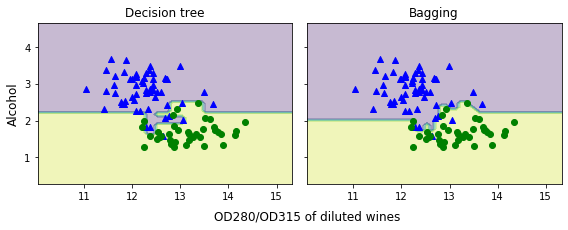

In [14]:
import numpy as np
import matplotlib.pyplot as plt

x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2,
                        sharex='col',
                        sharey='row',
                        figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, bag],
                        ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')

    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')

    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='OD280/OD315 of diluted wines',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)

#plt.savefig('images/07_08.png', dpi=300, bbox_inches='tight')
plt.show()

# Bootstrap aggregation

Bootstrapping is a sampling method without replacement. Suppose that one has a bag of 20 shaded marbles. Now you have to select 10 marbles one at a time. Each time you select a marble, you make a copy this marble into the sample and return the original one to the bag. It is possible, but extremely unlike, that you pick the same marble 10 times. But is really possible, that you pick some marbles more than once. Thus, by bootstraping the original sample, you can produce a sample with more blue marbles than the original one or less purple marbles than the original.  It is a statistical sampling method to introducing variability in the training procedure.

In a random forest, the bootstrap procedure happens in the backstage, in the training of each decision tree. Given that similar samples results in similar trees, we can explore the fact that decision trees are sensitive to perturbations in the training set and use bootstrap to produce such perturbations and induce a variability of splits and decision boundaries.

After this sampling and training step, each tree makes its individual prediction to be aggregate in the final prediction using the majority voting rule or the average regression. Thus a random forest aggregates the predictions of bootsrtapped decision trees in a bagging procedure.




# Random Forests

## A) Definitions of Random Forests

Bagging is an avegraging procedure of many noisy, but almost unbiased, models, and hence, reduces the variance. Trees are the ideal candidate for bagging, since they are almost unbiased by nature, and can capture complex structures in data. They are very noisy ,models, deeply sensitive to variations in trainning data, thus they take high advantage of the variance reduction approach of bagging.

An averaging of B i.i.d random variables, each with variance $\sigma^2$, has variance $\frac{\sigma^2}{B}$. If the variance is i.d(identicaly distributed), we have:

$$
\rho\sigma^2 + \frac{1-\rho}{B}\sigma^2
$$

As B increases, the second terms disappears, and since that the first term remains, them combinations os bagged trees benefits from averaging. Random Forests seeks for reduction of the variance by bagging trees with small correlations. One can archive this goal by randomly selecting the input variable at each tree. Thus, we train B trees in a dataset with p variables, and before each split, we randomly choose $m\leq p$ variables as candidates for split. Typically, m is chosen to be $\sqrt{p}$, and this value can be as low as $1$.

After $B$ of such trees $\{T(\vec{x},\theta_b)\}_{b=1}^B$, the random forest prediction is given by:

$$
f_{RF}^B(\vec{x}) = \frac{1}{B}\sum_{b=1}^B T(\vec{x},\theta_b)
$$

where $\theta_b$ represents the $b-th$ random forest tree in terms of splitting variables cutpoints at each node and terminal values i.e the set of all hyperparameters.



## B) Anatomy of a Random Forests

  A random forest regressor is the average of B regression trees. A simple average. Foa a classification, the simple average is changed by a voting criteria. The predicted class is the majority of votes of trees of the forest. But this isn't the only difference:

* For classification, the default value for $m$ is $\sqrt{p}$ and the minimum size of a node is 1.
* For regression, the default value of $m$ if $p/3$ and the minimum node size is 5.

In practice, the best value of $m$ depends upon the data, however these guidelines are useful as a starting point of hyperparameter tuning.

### B.1) Out-of-Bag Samples

Random forests has a very interesting properties, the out-of-bag samples. For each observation $z_i = (\vec{x_i},y_i)$, construct its random forest using bootstrap sample in which $z_i$ did not appear.

This kind of estimate is much alike to K-fold cross validation. Nut, unlike many other non-linear estimation, random forests can be trained in sequence and cross validation can be performed along the way. When OOB stabilizes, the training can be terminated.

### B.2) Feature Importance

Due to the subset selection of the random forest, we can identify the features that contributes more to produce good predictions. At each split in each tree, the improvement in the split-criterion is the importance measure attributed to be splitting variable and is accumulated along all training process, separately to each variable.

The OOB estimation of a random forest construct a feature importance that measures the prediction strength of each variable. In the training of the $b-th$ tree, the OOB samples are passed down the tree, and the prediction accuracy is recorded. Then, the value of the $j-th$ variable or randomly permuted in the OOB sample on the accuracy is again computed.

If the accuracy decreases as a result of this permuting is average of all trees, and is used to measure the importance of the $j-th$ variable. The randomization is effective in voids the effect of a variable, much like a LASSO linear regression.

### B.3) Overfitting

When the number of variables is large, but the fraction of relevant variables small, random forest tends to perform poorly. At each split, the chance of a bad choice is large. Also, there is a popular claim that random forests cannot leads to an overfit, like in the bagging method. This is not true. The random forest estimate approximate the expectation:

$$
\hat{f}_{rf} = \mathbb{E}_{\Theta}\[T(\vec{x},\theta)\] = \lim_{B\rightarrow \infty}\hat{f}_{rf}^{B}(\vec{x})
$$

In here, we distinct the fact that the distribution of hyperparameters $\Theta$ that is conditional to the training data, and this is because a random forest can overfit data. Since this is an average over B realizations of $\Theta$, a huge number of fully grown tree can include unecessary variance in the description and lead to overfit. A possible way out is to tune the tree hyper parameters during the train step.

## C) Analysis of a Random Forest

Now, we investigate the randomization applied in a random forest, with emphasis on the regression problem.

### C.1) The Effect of De-Correlation in Variance Reduction

In the $B \rightarrow \infty$ limit, the random forest estimator reads:

$$
\hat{f}_{rf}(\vec{x}) = \mathbb{E}_{\Theta|Z}T(\vec{x},\theta(Z))
$$

where we explicit the dependence of training data, here denoted by $\vec{z}$. The associate variance is given by:

$$
Var\hat{f}_{rf}(\vec{x}) = \rho(\vec{x})\sigma^2(\vec{x})
$$

Here:

* $\rho(\vec{x})$ is the sample correlation between any two trees:
$$
\rho(\vec{x}) = Corr[T(\vec{x},\theta_i(Z))T(\vec{x},\theta_j(Z))], \:\: i \neq j
$$
* $\sigma^2(\vec{x})$ is the sampling variance of a single tree:
$$
\sigma^2(\vec{x}) = Var\[T(\vec{x},\Theta(\vec{z}))\]
$$

Now, care must be take, since despite of the appearance, this is not the average correlation of trees in a given random forest. The immediate interpretation is that we trained N trees, built a random forest, and them we compute the pairwise correlation matrix in order to perform the final model evaluation. This is not the case. The distinction is represented by the $\vec{x}$ dependence. This correlation is not relevant in the averaging procedure. $\rho(\vec{x})$ is a theoretical correlation between a pair of random forests trees evaluated at $\vec{x}$, and to do so, we make several repetitions of draws of the training sample $\mathbb{Z}$ from the population an them we drawn any two trees of a random forest. This is the statistical correlation induced by a sampling distribution of $\mathbb{Z}$ and $\Theta$. The variability average has two main features:

1. Conditional on $\mathbb{Z}$, due to bootstrap sampling and the feature selection at each split.
2. A reflexus of the sampling variability of the training sample it self.


### C.2) Bias

The bias of a random forest is the same of a single tree and is also typically greater than the bias of an unprunned tree over the same dataset. Thus, the gain of the random forest algorithm is solely the variance reduction.
In addition, any discussion of bias depends upon the knowledge of the ground truth model, that is always unknown. In fact, there is a few general trends like, as the number of used variables decreased, the bias increases, a very similar behaviour as in ridge regression.

# Random Forest Hyperparameters

Random forests has two class of hyperparameters. The first one is related with the bootstrap procedure and the second are decision tree hyperparameters.

In [15]:
# loading the model instance
from sklearn.ensemble import RandomForestClassifier

In [16]:

iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =train_test_split(X, y,
                                                   test_size=0.5,
                                                   random_state=1,
                                                   stratify=y)

In [17]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)


In [18]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3, rfc])

clf_labels += ['Random Forest']
all_clf = [pipe1, clf2, pipe3, mv_clf, rfc]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
ROC AUC: 0.98 (+/- 0.05) [Majority voting]
ROC AUC: 0.98 (+/- 0.05) [Random Forest]


## Bootstrap Hyperparameters

### oob_score

Since random forest selects the trees using bagging, with replacement, some samples should remain untouched. One can think to hold these samples and use than as test set. After fit the model on one tree, they can be tested using this teste set. This is done by setting the hyperparameter oob_score to True:

In [26]:
rfc = RandomForestClassifier(oob_score=True,n_estimators=100, random_state=42)
rfc.fit(X_train,y_train)
rfc.oob_score_

0.92

The bigger the number of estimators, more out of sample estimations will be performed and more information about model accuracy will be avaliable.

In [27]:
rfc = RandomForestClassifier(oob_score=True,n_estimators=300, random_state=42)
rfc.fit(X_train,y_train)
rfc.oob_score_

0.9

### n_estimators

The power of random forests relies on the bagging properties, and the bagging properties depends upon the number of trees in the forest. There is no general rules to estimate how much trees we need in the dataset. The default of sklearn to small datasets is 100. Larger datasets may require 500 or more:

## warm_start

Since we don't have a clear rule to assign the best number of trees, it will have to be decided by a hyperparameter tunning procedure. The wram start parameter is great for such task. When set to true, we do not need to start from the beginning to add more trees in the training step. If you change the number of trees from 100 to 200, it doubles the training time, thus we have to wait the time to train 100 trees and more twice this time for the 200 trees. With warm_start=True, we just waot for the time of another 100 trees, because the training procedure starts where the 100th of the last model stopped.

## Bootstrap

Random forests are traditionally bootstrapped, the bootstrap hyperparameter may set to false. In this case, oob_score cannot be used. This is an option only when we have underfitting.

## Verbose

The verbose hyperparameter may be changed to a higher number to display more information when training a model.

## Decision Tree Hyperparameters

Random forests also inherits almost all hyperparameters from DecisionTrees:

* max_depth: Number of times splits occurs.
* max_features: Number of features to be considered when split.
* min_samples_split: Increase the number of samples required for a new split.
* min_impurity_decreases: Limits splits to decrease impurity greater than a threshold.
* min_samples_leaf: Increases the minimum number of samples required for a node to be a leaf.
* min_weight_fraction_leaf: The fractions of total weights required to be a leaf.

Scikit-Learn has a very convenient suit for ensemble methods:
1. Set the hyperparameter max_features to a lower value than the number of variables of the problem. This should force a discrepancy between trees.
2. Set the regularization parameter min_weight_fraction_leaf to a sufficient large value, such as 5%, so that out-of-bag accuracy converges to out-of-sample K-Fold cross validation
3. Use the module BaggingClassifier on DecisionTreeClassifier where max_sample is set to the average uniqueness (avgU) between samples.
4. Use BaggingClassifier on RandomForestClassifier
5. Modify the RF class to replace standard bootstrapping with sequential bootstrapping.

In [19]:
base_credit = pd.read_csv('credit_risk_dataset.csv')

In [20]:
base_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB



person_age: Age
person_income: Annual Income
personhomeownership: Home ownership
personemplength: Employment length (in years)
loan_intent: Loan intent
loan_grade: Loan grade
loan_amnt: Loan amount
loanintrate: Interest rate
loan_status: Loan status (0 is non default 1 is default)
loanpercentincome: Percent income
cbpersondefaultonfile: Historical default
cbpresoncredhistlength: Credit history length

In [21]:
base_credit["person_emp_length"].fillna(base_credit["person_emp_length"].median(), inplace=True)
base_credit["loan_int_rate"].fillna(base_credit["loan_int_rate"].median(), inplace=True)
base_credit.drop_duplicates(inplace=True)

In [22]:
X_credit = base_credit[['person_age', 'person_income', 'person_home_ownership',
                        'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
                        'loan_int_rate', 'loan_percent_income',
                        'cb_person_default_on_file', 'cb_person_cred_hist_length']]
y_credit = base_credit['loan_status']

In [23]:
X_credit = pd.get_dummies(X_credit)

In [24]:
X_credit_train, X_credit_test, y_credit_train, y_credit_test = train_test_split(X_credit,y_credit, test_size = 0.3, random_state=84)


In [25]:
clf1 = LogisticRegression(penalty='l2',
                          C=0.001,
                          solver='lbfgs',
                          random_state=1)

clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=0)

clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']

print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_credit_train,
                             y=y_credit_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.87 (+/- 0.01) [Logistic regression]
ROC AUC: 0.67 (+/- 0.01) [Decision tree]
ROC AUC: 0.79 (+/- 0.01) [KNN]


In [40]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3, rfc])

clf_labels = ['Logistic regression','Decision tree','KNN','Random Forest','Bagging']
all_clf = [pipe1, clf2, pipe3, rfc, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_credit_train,
                             y=y_credit_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

ROC AUC: 0.87 (+/- 0.01) [Logistic regression]
ROC AUC: 0.67 (+/- 0.01) [Decision tree]
ROC AUC: 0.79 (+/- 0.01) [KNN]
ROC AUC: 0.93 (+/- 0.01) [Random Forest]
ROC AUC: 0.92 (+/- 0.01) [Bagging]


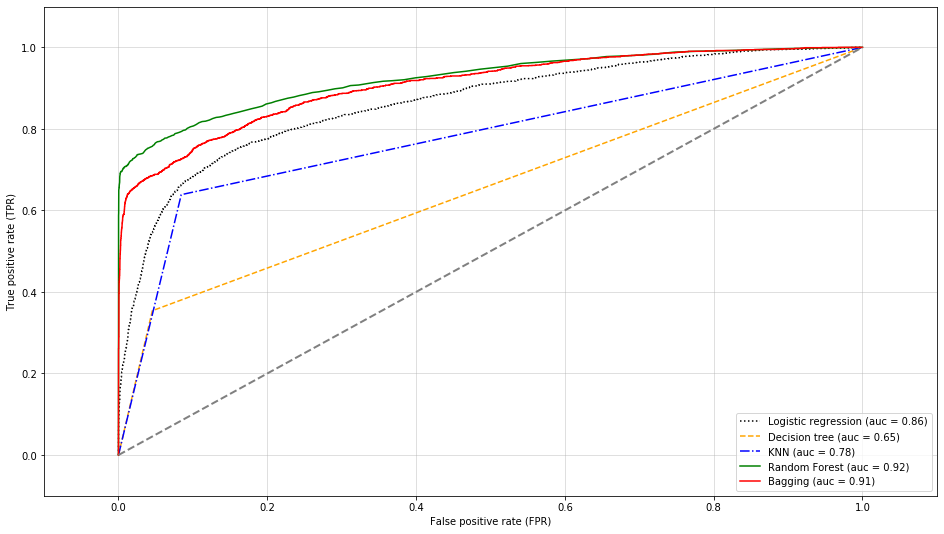

In [43]:
colors = ['black', 'orange', 'blue', 'green','red']
linestyles = [':', '--', '-.', '-','-']
plt.figure(figsize=(16,9))
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):

    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_credit_train,
                     y_credit_train).predict_proba(X_credit_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_credit_test,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')


#plt.savefig('images/07_04', dpi=300)
plt.show()

In [26]:
loan_data_inputs_train = pd.read_csv('credit_train_dataset_final.csv', index_col = 0)
loan_data_targets_train = pd.read_csv('loan_data_targets_train.csv', index_col = 0)
loan_data_inputs_test = pd.read_csv('credit_test_dataset_final.csv', index_col = 0)
loan_data_targets_test = pd.read_csv('loan_data_targets_test.csv', index_col = 0)

In [27]:
loan_data_inputs_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 373028 entries, 427211 to 121958
Columns: 103 entries, grade:A to mths_since_last_record:81-86
dtypes: int64(103)
memory usage: 296.0 MB


In [28]:
loan_data_targets_train.dropna(inplace=True)
loan_data_targets_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 373028 entries, 427211 to 121958
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   good_bad  373028 non-null  int64
dtypes: int64(1)
memory usage: 5.7 MB


In [81]:
loan_data_targets_train.shape

(373028, 1)

In [77]:
loan_data_targets_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93257 entries, 362514 to 167512
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   good_bad  93257 non-null  int64
dtypes: int64(1)
memory usage: 1.4 MB


In [78]:
loan_data_inputs_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93257 entries, 362514 to 167512
Columns: 103 entries, grade:A to mths_since_last_record:81-86
dtypes: int64(103)
memory usage: 74.0 MB


In [79]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3, rfc])

clf_labels = ['Logistic regression','Decision tree','KNN','Random Forest','Bagging']
all_clf = [pipe1, clf2, pipe3, rfc, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=loan_data_inputs_train,
                             y=loan_data_targets_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

C:\Users\Pichau\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Pichau\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Pichau\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Pichau\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

ROC AUC: 0.70 (+/- 0.00) [Logistic regression]
ROC AUC: 0.57 (+/- 0.00) [Decision tree]


C:\Users\Pichau\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\Pichau\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\Pichau\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\Pichau\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

ROC AUC: 0.52 (+/- 0.00) [KNN]


C:\Users\Pichau\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Pichau\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Pichau\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Pichau\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector 

ROC AUC: 0.67 (+/- 0.00) [Random Forest]


C:\Users\Pichau\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Pichau\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Pichau\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Pichau\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y

ROC AUC: 0.67 (+/- 0.00) [Bagging]


In [84]:
rfc = RandomForestClassifier(oob_score=True, random_state=42)

In [85]:
n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10]

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,
              min_samples_split = min_samples_split,
              min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(rfc, hyperF, cv = 3, verbose = 1,
                     n_jobs = -1)
bestF = gridF.fit(loan_data_inputs_train, loan_data_targets_train)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


KeyboardInterrupt: 

In [ ]:
forestOpt = RandomForestClassifier(random_state = 42, max_depth = bestF.best_params_['max_depth'],     n_estimators = bestF.best_params_['n_estimators'], min_samples_split = bestF.best_params_['min_samples_split'], min_samples_leaf = bestF.best_params_['min_samples_leaf'])

modelOpt = forestOpt.fit(loan_data_inputs_train, loan_data_targets_train)
y_pred = modelOpt.predict(loan_data_inputs_test)

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(loan_data_targets_test))]
# predict probabilities
lr_probs = modelOpt.predict_proba(loan_data_inputs_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(loan_data_targets_test, ns_probs)
lr_auc = roc_auc_score(loan_data_targets_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Opt. Random Forest: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(loan_data_targets_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(loan_data_targets_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Opt. Random Forest')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()